In [56]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [57]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\data\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [58]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

valid_df = matched[matched['partition']==1]

In [59]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [60]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [61]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

In [62]:
# Read dataframe with training metrics
df = pd.read_pickle('aws\\Models\\run2__df.pkl') #e.g. pd.read_pickle('df.pkl')

In [63]:
df.loc[3,'activations']

[<function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>]

In [64]:
df

layers                                        activations  \
1       2  [<function relu at 0x000001950E9F4E18>, <built...   
2       2  [<function relu at 0x000001950E9F4E18>, <funct...   
3       2  [<function relu at 0x000001950E9F4E18>, <funct...   
4       2  [<function relu at 0x000001950E9F4E18>, <funct...   
5       3  [<function relu at 0x000001950E9F4E18>, <funct...   
6       4  [<function relu at 0x000001950E9F4E18>, <funct...   
7       3  [<function relu at 0x000001950E9F4E18>, <funct...   
8       4  [<function relu at 0x000001950E9F4E18>, <funct...   

   conv_out_channels  kernel_size  conv_stride  maxpool  dropout  batchnorm  \
1                 32            5            1        2      0.2       True   
2                 32            5            1        2      0.2       True   
3                 64            5            1        2      0.8       True   
4                 32            5            1        2      0.2       True   
5                 32            5            1        2      0.2       True   
6                 16            5            1        2      0.2       True   
7                 32            5            1        2      0.2       True   
8                 16            5            1        2      0.2       True   

  optimizer  learning_rate  weight_decay  batch_size  num_epochs  \
1      Adam          0.001          0.01         128           5   
2      Adam          0.001          0.01         128           5   
3      Adam          0.001          0.10         128           5   
4      Adam          0.001          0.01         128           5   
5      Adam          0.001          0.01         128           5   
6      Adam          0.001          0.01         128           5   
7      Adam          0.001          0.01         128           5   
8      Adam          0.001          0.01         128           5   

            net                                         train_loss  \
1  run2__model1  [0.787320077419281, 1.2756198644638062, 0.6986...   
2  run2__model2  [0.7270410656929016, 1.192880392074585, 0.9200...   
3  run2__model3  [0.8246510624885559, 1.9678641557693481, 1.537...   
4  run2__model4  [0.852070152759552, 0.7770803570747375, 0.7371...   
5  run2__model5  [0.8077120780944824, 1.0716813802719116, 1.078...   
6  run2__model6  [0.7874405384063721, 0.8448547720909119, 0.667...   
7  run2__model7  [0.7538514733314514, 1.1628611087799072, 1.195...   
8  run2__model8  [0.7434457540512085, 1.2706197500228882, 0.632...   

                                          train_accs  \
1  [0.3984375, 0.546875, 0.7109375, 0.671875, 0.6...   
2  [0.46875, 0.546875, 0.609375, 0.6171875, 0.710...   
3  [0.4140625, 0.5078125, 0.53125, 0.609375, 0.59...   
4  [0.390625, 0.6328125, 0.6484375, 0.6171875, 0....   
5  [0.453125, 0.6484375, 0.6171875, 0.609375, 0.7...   
6  [0.4375, 0.5859375, 0.6484375, 0.640625, 0.648...   
7  [0.484375, 0.65625, 0.5859375, 0.65625, 0.6328...   
8  [0.5859375, 0.5078125, 0.7109375, 0.6640625, 0...   

                                    valid_train_loss  \
1  [0.7255932688713074, 0.27513042092323303, 0.24...   
2  [5.199552536010742, 0.27074000239372253, 0.254...   
3  [3.5466063022613525, 0.37123364210128784, 0.27...   
4  [2.5280070304870605, 0.27008363604545593, 0.23...   
5  [0.834692120552063, 0.2967720031738281, 0.2535...   
6  [0.7212352156639099, 0.2527103126049042, 0.226...   
7  [1.578385353088379, 0.25720539689064026, 0.262...   
8  [2.1032886505126953, 0.23763082921504974, 0.23...   

                                    valid_train_accs valid_loss valid_accs  
1  [0.5130618810653687, 0.8896159529685974, 0.895...   0.207665   0.910455  
2  [0.5176926255226135, 0.8867971897125244, 0.894...   0.199299    0.91574  
3  [0.4940856695175171, 0.8414456248283386, 0.881...   0.291153    0.89017  
4  [0.46172043681144714, 0.8894146084785461, 0.89...   0.208755   0.913626  
5  [0.515125572681427, 0.8718478083610535, 0.8921...   0.204349   0.914632 

In [65]:
[np.mean(df.loc[i,'train_accs'][-300:]) for i in range(1,9)]

[0.9064977133274078,
 0.9117727386951446,
 0.8700038109223048,
 0.9110581807295481,
 0.9081040394306182,
 0.9033841462930043,
 0.9067339938879013,
 0.9040008890628815]

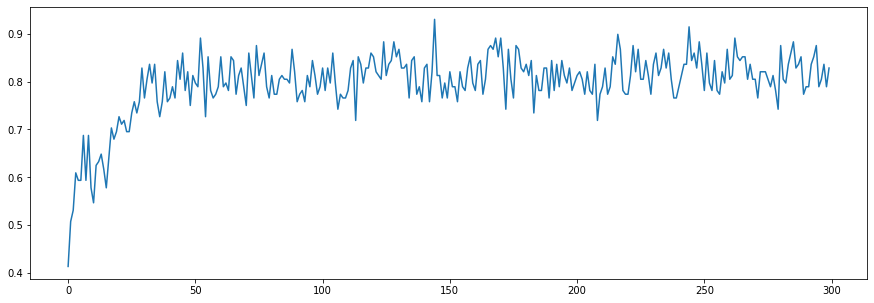

In [66]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[3,'train_accs'][0:300])
ind = [300*i for i in range(0,22)]
#plt.plot(ind,df.loc[3,'valid_train_accs'])

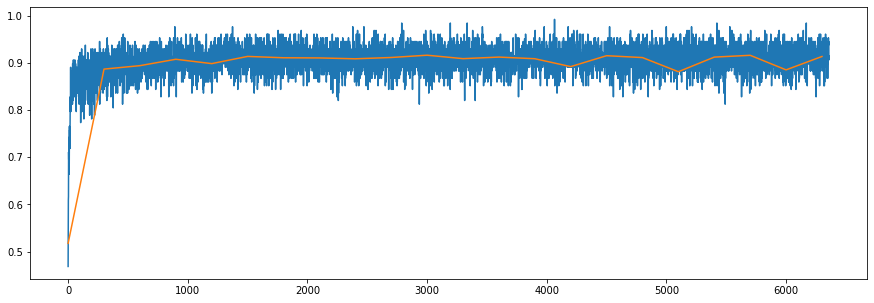

In [67]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'])
ind = [300*i for i in range(0,22)]
plt.plot(ind,df.loc[2,'valid_train_accs'])

In [69]:
# Change i to the model number you want to load
i = 2
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [70]:
# Load network, choose the model i
net.load_state_dict(torch.load('aws\\Models\\run2__model2.dms',map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (l_out): Linear(in_features=11520, out_features=2, bias=False)
)

In [73]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

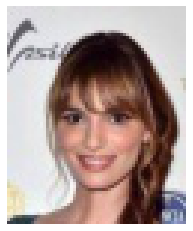

True Label:  tensor(1)
Model output:  tensor([-3.1481,  3.1495])
File name:  171018.jpg


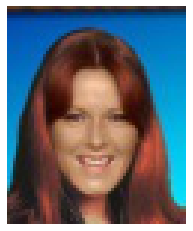

True Label:  tensor(1)
Model output:  tensor([-4.3008,  4.2988])
File name:  169056.jpg


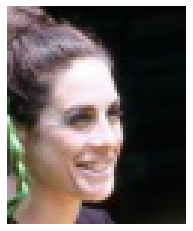

True Label:  tensor(1)
Model output:  tensor([-0.8266,  0.8252])
File name:  163010.jpg


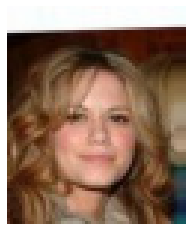

True Label:  tensor(0)
Model output:  tensor([ 0.2449, -0.2447])
File name:  180264.jpg


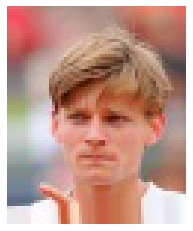

True Label:  tensor(0)
Model output:  tensor([ 2.5336, -2.5329])
File name:  179967.jpg


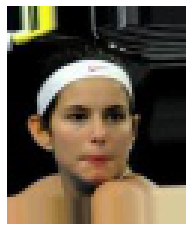

True Label:  tensor(0)
Model output:  tensor([ 3.6541, -3.6535])
File name:  167447.jpg


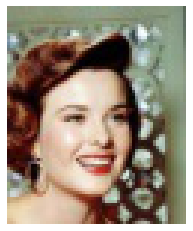

True Label:  tensor(1)
Model output:  tensor([-4.6863,  4.6835])
File name:  164729.jpg


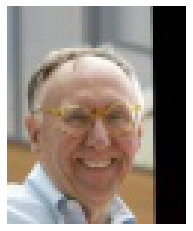

True Label:  tensor(1)
Model output:  tensor([-0.6603,  0.6597])
File name:  166510.jpg


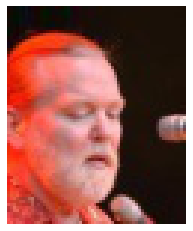

True Label:  tensor(0)
Model output:  tensor([ 2.2031, -2.2033])
File name:  164965.jpg


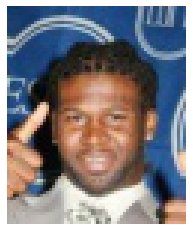

True Label:  tensor(1)
Model output:  tensor([-1.0371,  1.0377])
File name:  167762.jpg


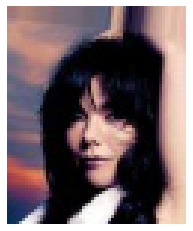

True Label:  tensor(0)
Model output:  tensor([ 2.0200, -2.0177])
File name:  178109.jpg


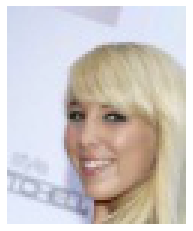

True Label:  tensor(1)
Model output:  tensor([-1.2882,  1.2876])
File name:  165340.jpg


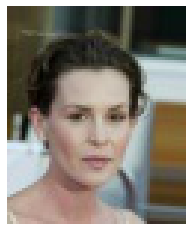

True Label:  tensor(0)
Model output:  tensor([ 2.3298, -2.3291])
File name:  165028.jpg


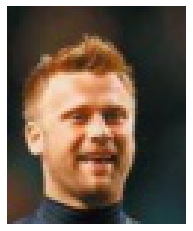

True Label:  tensor(0)
Model output:  tensor([-0.1205,  0.1201])
File name:  177394.jpg


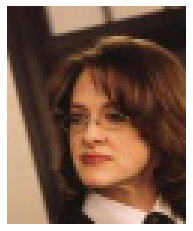

True Label:  tensor(0)
Model output:  tensor([ 2.0868, -2.0876])
File name:  163882.jpg


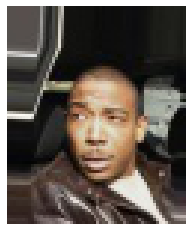

True Label:  tensor(0)
Model output:  tensor([ 3.5178, -3.5169])
File name:  164734.jpg


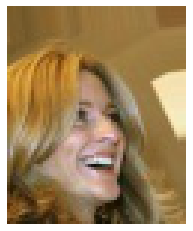

True Label:  tensor(1)
Model output:  tensor([-0.5591,  0.5588])
File name:  178385.jpg


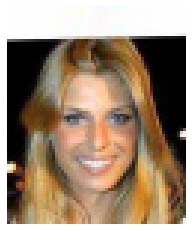

True Label:  tensor(1)
Model output:  tensor([-4.0006,  3.9986])
File name:  176382.jpg


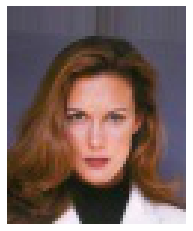

True Label:  tensor(0)
Model output:  tensor([ 3.1552, -3.1545])
File name:  173999.jpg


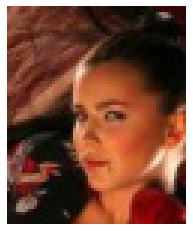

True Label:  tensor(0)
Model output:  tensor([ 1.5507, -1.5505])
File name:  166440.jpg


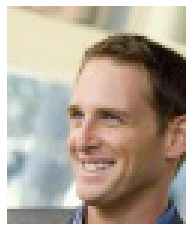

True Label:  tensor(1)
Model output:  tensor([-1.6225,  1.6216])
File name:  167230.jpg


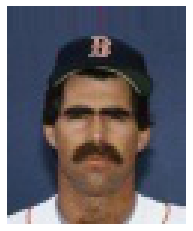

True Label:  tensor(0)
Model output:  tensor([ 0.7550, -0.7545])
File name:  165600.jpg


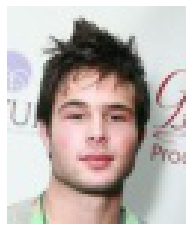

True Label:  tensor(0)
Model output:  tensor([ 1.7205, -1.7197])
File name:  170243.jpg


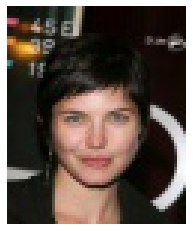

True Label:  tensor(1)
Model output:  tensor([-0.2151,  0.2186])
File name:  177366.jpg


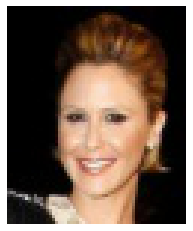

True Label:  tensor(1)
Model output:  tensor([-3.6027,  3.6004])
File name:  170781.jpg


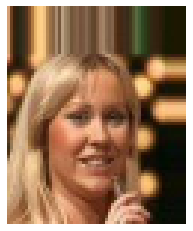

True Label:  tensor(1)
Model output:  tensor([-1.3656,  1.3651])
File name:  174116.jpg


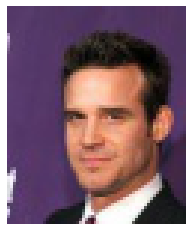

True Label:  tensor(0)
Model output:  tensor([ 1.3401, -1.3401])
File name:  165545.jpg


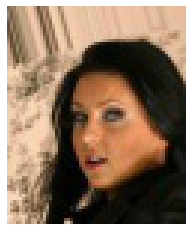

True Label:  tensor(0)
Model output:  tensor([ 1.7907, -1.7896])
File name:  171986.jpg


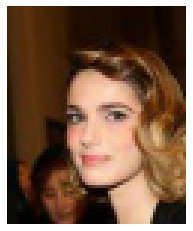

True Label:  tensor(0)
Model output:  tensor([ 0.8329, -0.8331])
File name:  169609.jpg


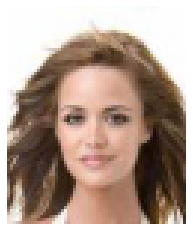

True Label:  tensor(0)
Model output:  tensor([-0.3822,  0.3820])
File name:  173182.jpg


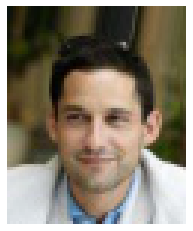

True Label:  tensor(1)
Model output:  tensor([-0.0989,  0.0980])
File name:  169086.jpg


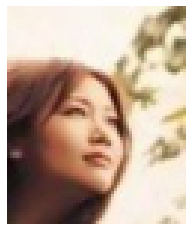

True Label:  tensor(0)
Model output:  tensor([ 3.1072, -3.1061])
File name:  164377.jpg


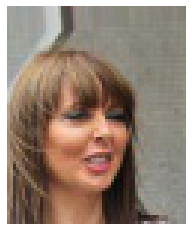

True Label:  tensor(1)
Model output:  tensor([-0.8080,  0.8095])
File name:  162973.jpg


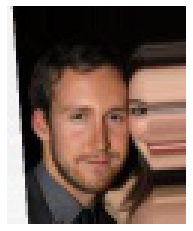

True Label:  tensor(0)
Model output:  tensor([ 1.6041, -1.6026])
File name:  175891.jpg


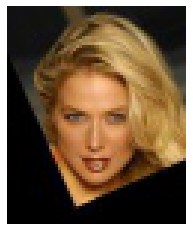

True Label:  tensor(1)
Model output:  tensor([ 1.0477, -1.0465])
File name:  181381.jpg


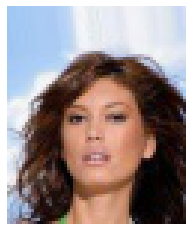

True Label:  tensor(0)
Model output:  tensor([ 1.7876, -1.7860])
File name:  174269.jpg


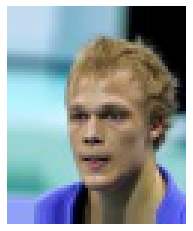

True Label:  tensor(0)
Model output:  tensor([ 2.8296, -2.8298])
File name:  169440.jpg


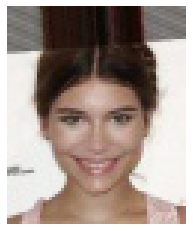

True Label:  tensor(1)
Model output:  tensor([-2.5181,  2.5170])
File name:  178339.jpg


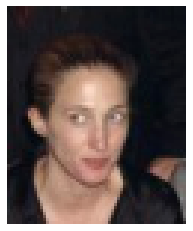

True Label:  tensor(0)
Model output:  tensor([ 2.1458, -2.1443])
File name:  176708.jpg


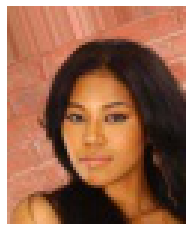

True Label:  tensor(0)
Model output:  tensor([ 1.3161, -1.3158])
File name:  168864.jpg


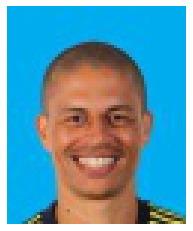

True Label:  tensor(1)
Model output:  tensor([-5.6918,  5.6885])
File name:  181609.jpg


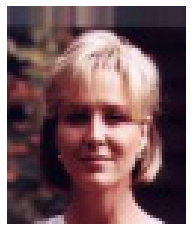

True Label:  tensor(0)
Model output:  tensor([-0.8418,  0.8407])
File name:  165779.jpg


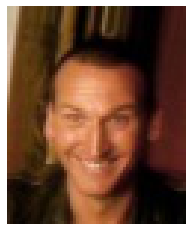

True Label:  tensor(1)
Model output:  tensor([-2.4785,  2.4771])
File name:  164774.jpg


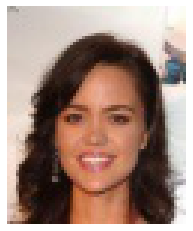

True Label:  tensor(1)
Model output:  tensor([-3.7278,  3.7269])
File name:  168966.jpg


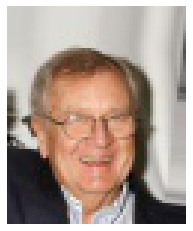

True Label:  tensor(1)
Model output:  tensor([-1.1879,  1.1871])
File name:  164517.jpg


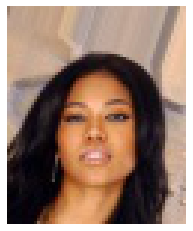

True Label:  tensor(0)
Model output:  tensor([ 1.0363, -1.0363])
File name:  172328.jpg


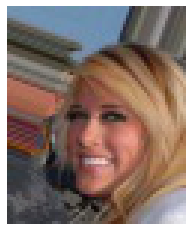

True Label:  tensor(1)
Model output:  tensor([-1.8708,  1.8695])
File name:  171421.jpg


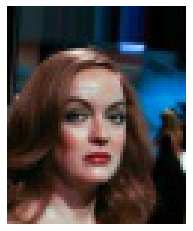

True Label:  tensor(0)
Model output:  tensor([ 2.7506, -2.7494])
File name:  166707.jpg


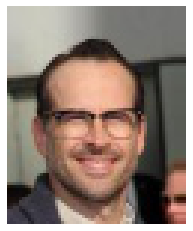

True Label:  tensor(1)
Model output:  tensor([-2.9927,  2.9898])
File name:  163081.jpg


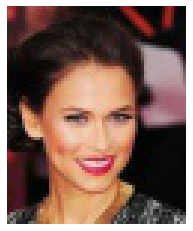

True Label:  tensor(1)
Model output:  tensor([-4.1036,  4.1043])
File name:  171923.jpg


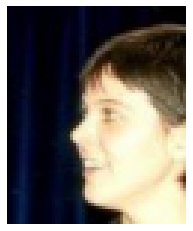

True Label:  tensor(1)
Model output:  tensor([ 0.9773, -0.9764])
File name:  175277.jpg


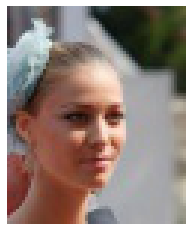

True Label:  tensor(0)
Model output:  tensor([ 0.3961, -0.3977])
File name:  170147.jpg


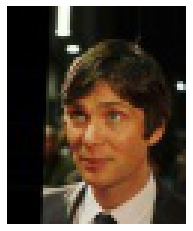

True Label:  tensor(0)
Model output:  tensor([ 1.1034, -1.1032])
File name:  170914.jpg


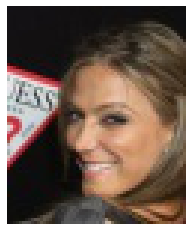

True Label:  tensor(1)
Model output:  tensor([-1.4036,  1.4021])
File name:  176157.jpg


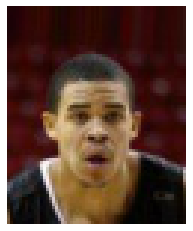

True Label:  tensor(0)
Model output:  tensor([ 3.4763, -3.4770])
File name:  173314.jpg


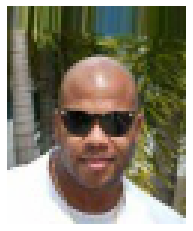

True Label:  tensor(0)
Model output:  tensor([-1.0023,  1.0019])
File name:  172252.jpg


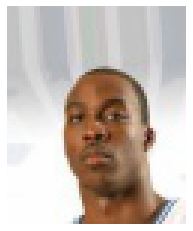

True Label:  tensor(0)
Model output:  tensor([ 1.6686, -1.6683])
File name:  162824.jpg


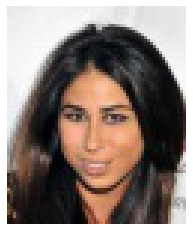

True Label:  tensor(1)
Model output:  tensor([-1.0008,  1.0005])
File name:  167853.jpg


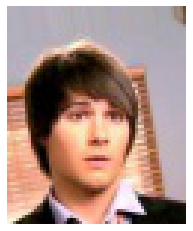

True Label:  tensor(0)
Model output:  tensor([ 4.5907, -4.5859])
File name:  168944.jpg


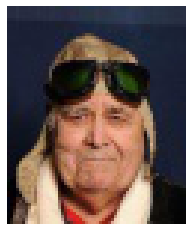

True Label:  tensor(1)
Model output:  tensor([ 0.3100, -0.3083])
File name:  171035.jpg


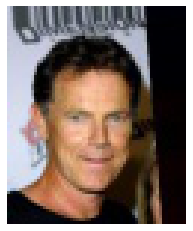

True Label:  tensor(1)
Model output:  tensor([-0.2250,  0.2266])
File name:  172950.jpg


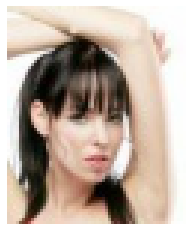

True Label:  tensor(0)
Model output:  tensor([ 2.5698, -2.5681])
File name:  168839.jpg


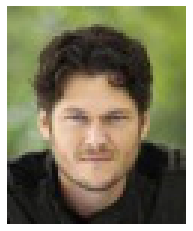

True Label:  tensor(1)
Model output:  tensor([ 1.0962, -1.0963])
File name:  179589.jpg


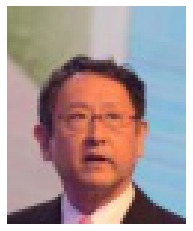

True Label:  tensor(0)
Model output:  tensor([ 4.0319, -4.0310])
File name:  178348.jpg


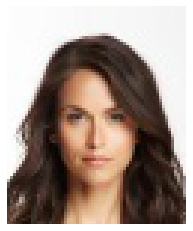

True Label:  tensor(0)
Model output:  tensor([ 2.1193, -2.1193])
File name:  172494.jpg


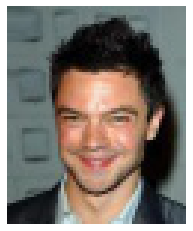

True Label:  tensor(1)
Model output:  tensor([-4.4357,  4.4362])
File name:  171276.jpg


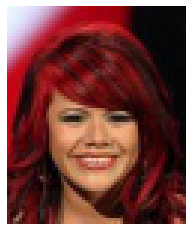

True Label:  tensor(1)
Model output:  tensor([-5.3003,  5.2996])
File name:  177692.jpg


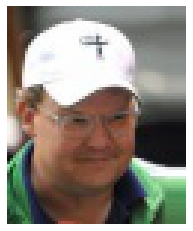

True Label:  tensor(1)
Model output:  tensor([-0.0672,  0.0684])
File name:  169487.jpg


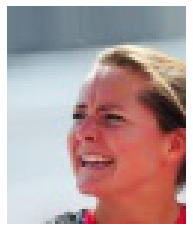

True Label:  tensor(1)
Model output:  tensor([-0.5626,  0.5625])
File name:  176418.jpg


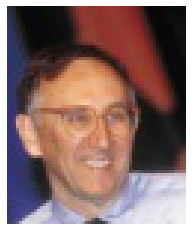

True Label:  tensor(1)
Model output:  tensor([-0.5188,  0.5167])
File name:  170659.jpg


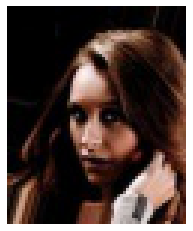

True Label:  tensor(0)
Model output:  tensor([ 2.2011, -2.2007])
File name:  166286.jpg


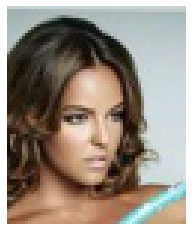

True Label:  tensor(0)
Model output:  tensor([ 2.3683, -2.3676])
File name:  182590.jpg


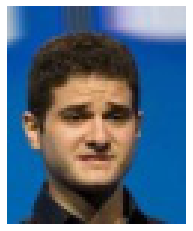

True Label:  tensor(1)
Model output:  tensor([ 0.5247, -0.5256])
File name:  165221.jpg


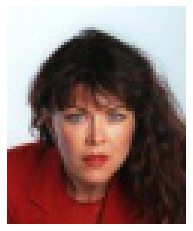

True Label:  tensor(0)
Model output:  tensor([ 3.5730, -3.5700])
File name:  174181.jpg


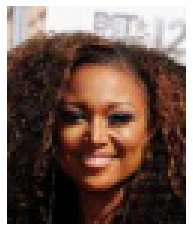

True Label:  tensor(1)
Model output:  tensor([-3.7042,  3.7023])
File name:  175813.jpg


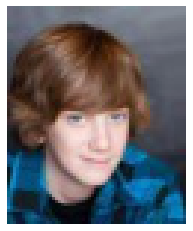

True Label:  tensor(1)
Model output:  tensor([ 1.0348, -1.0334])
File name:  181375.jpg


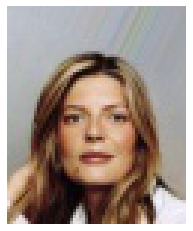

True Label:  tensor(0)
Model output:  tensor([ 1.9468, -1.9462])
File name:  165990.jpg


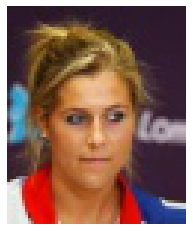

True Label:  tensor(0)
Model output:  tensor([ 1.9024, -1.9038])
File name:  173662.jpg


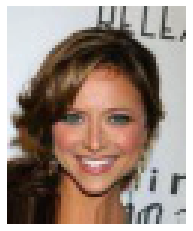

True Label:  tensor(1)
Model output:  tensor([-5.1989,  5.1987])
File name:  182620.jpg


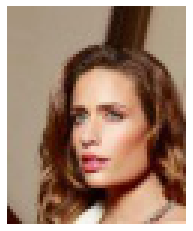

True Label:  tensor(0)
Model output:  tensor([ 3.0880, -3.0872])
File name:  165377.jpg


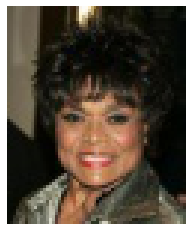

True Label:  tensor(1)
Model output:  tensor([-2.6555,  2.6569])
File name:  165143.jpg


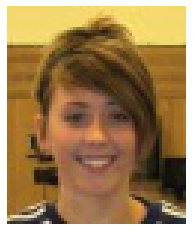

True Label:  tensor(1)
Model output:  tensor([-1.9110,  1.9101])
File name:  181017.jpg


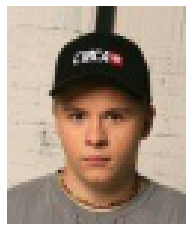

True Label:  tensor(0)
Model output:  tensor([ 3.6819, -3.6795])
File name:  175574.jpg


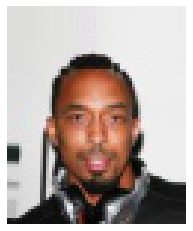

True Label:  tensor(0)
Model output:  tensor([ 0.7732, -0.7745])
File name:  170980.jpg


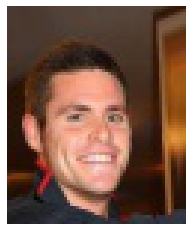

True Label:  tensor(1)
Model output:  tensor([-1.3541,  1.3526])
File name:  176653.jpg


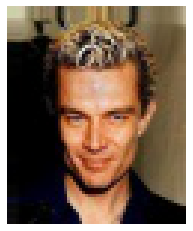

True Label:  tensor(1)
Model output:  tensor([-2.3668,  2.3661])
File name:  175337.jpg


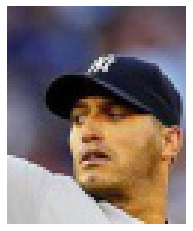

True Label:  tensor(0)
Model output:  tensor([ 3.6393, -3.6352])
File name:  170969.jpg


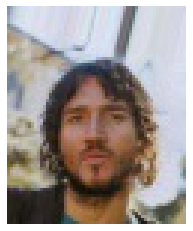

True Label:  tensor(0)
Model output:  tensor([ 2.0426, -2.0408])
File name:  164968.jpg


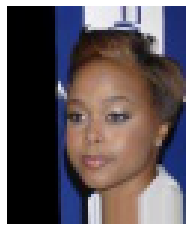

True Label:  tensor(0)
Model output:  tensor([ 1.8509, -1.8507])
File name:  165893.jpg


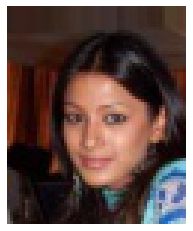

True Label:  tensor(0)
Model output:  tensor([ 0.1029, -0.1012])
File name:  164798.jpg


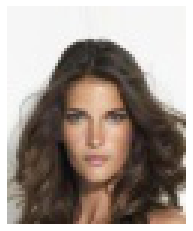

True Label:  tensor(0)
Model output:  tensor([ 3.3229, -3.3226])
File name:  172581.jpg


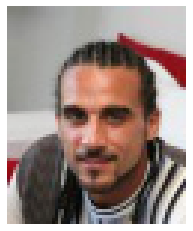

True Label:  tensor(0)
Model output:  tensor([-0.1782,  0.1771])
File name:  175351.jpg


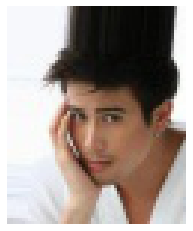

True Label:  tensor(0)
Model output:  tensor([ 0.7848, -0.7858])
File name:  174080.jpg


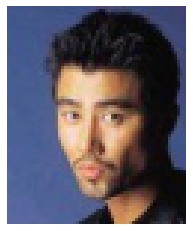

True Label:  tensor(0)
Model output:  tensor([ 2.4662, -2.4656])
File name:  174597.jpg


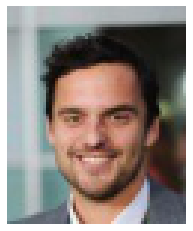

True Label:  tensor(1)
Model output:  tensor([-3.6421,  3.6405])
File name:  174008.jpg


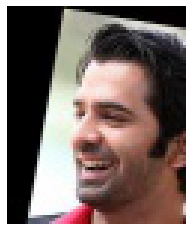

True Label:  tensor(1)
Model output:  tensor([ 0.5511, -0.5515])
File name:  177317.jpg


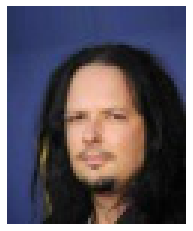

True Label:  tensor(0)
Model output:  tensor([ 2.8879, -2.8879])
File name:  169912.jpg


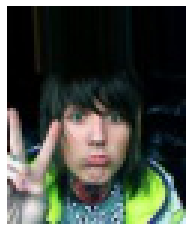

True Label:  tensor(0)
Model output:  tensor([ 3.3477, -3.3462])
File name:  176046.jpg


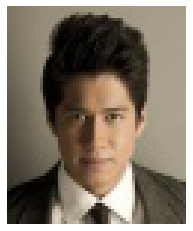

True Label:  tensor(0)
Model output:  tensor([ 2.2525, -2.2518])
File name:  167695.jpg


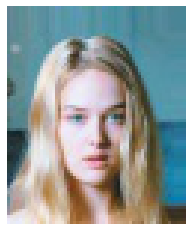

True Label:  tensor(0)
Model output:  tensor([ 2.7636, -2.7617])
File name:  176328.jpg


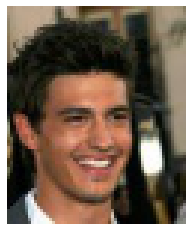

True Label:  tensor(1)
Model output:  tensor([-4.2922,  4.2886])
File name:  165860.jpg


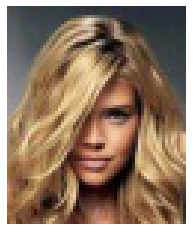

True Label:  tensor(1)
Model output:  tensor([ 0.1124, -0.1091])
File name:  169076.jpg


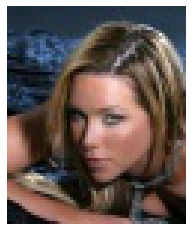

True Label:  tensor(0)
Model output:  tensor([ 2.1348, -2.1353])
File name:  172081.jpg


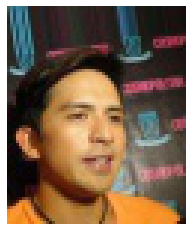

True Label:  tensor(0)
Model output:  tensor([ 1.3049, -1.3050])
File name:  174407.jpg


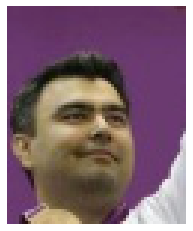

True Label:  tensor(1)
Model output:  tensor([ 0.8491, -0.8502])
File name:  172725.jpg


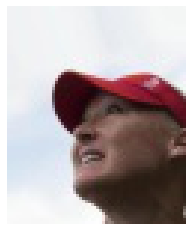

True Label:  tensor(0)
Model output:  tensor([ 2.3493, -2.3480])
File name:  169703.jpg


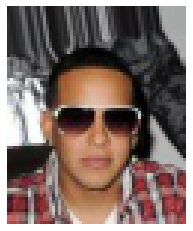

True Label:  tensor(0)
Model output:  tensor([ 1.7791, -1.7795])
File name:  181705.jpg


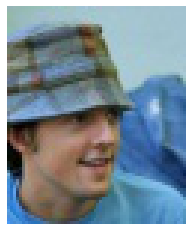

True Label:  tensor(1)
Model output:  tensor([-0.8696,  0.8693])
File name:  178623.jpg


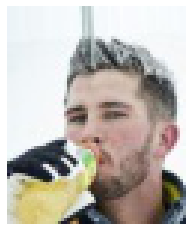

True Label:  tensor(0)
Model output:  tensor([ 2.1353, -2.1338])
File name:  180184.jpg


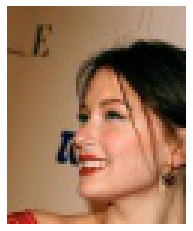

True Label:  tensor(1)
Model output:  tensor([ 0.5935, -0.5940])
File name:  173915.jpg


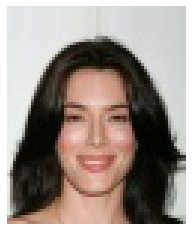

True Label:  tensor(1)
Model output:  tensor([-4.1703,  4.1688])
File name:  163233.jpg


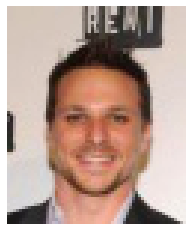

True Label:  tensor(1)
Model output:  tensor([-2.8162,  2.8169])
File name:  166358.jpg


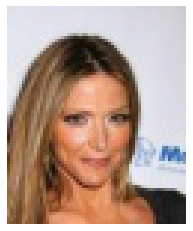

True Label:  tensor(1)
Model output:  tensor([-0.1540,  0.1558])
File name:  174802.jpg


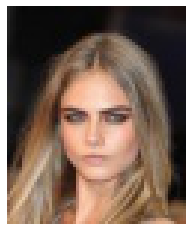

True Label:  tensor(0)
Model output:  tensor([ 2.5481, -2.5483])
File name:  181433.jpg


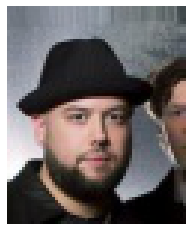

True Label:  tensor(0)
Model output:  tensor([ 3.1366, -3.1343])
File name:  173679.jpg


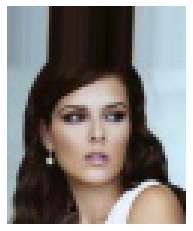

True Label:  tensor(0)
Model output:  tensor([ 4.2316, -4.2283])
File name:  172927.jpg


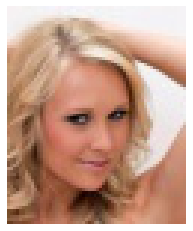

True Label:  tensor(1)
Model output:  tensor([ 0.3254, -0.3262])
File name:  178736.jpg


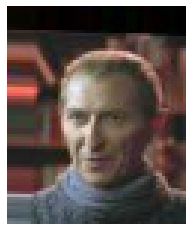

True Label:  tensor(0)
Model output:  tensor([ 1.4403, -1.4402])
File name:  173206.jpg


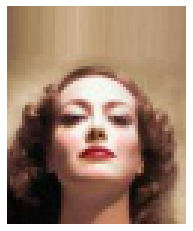

True Label:  tensor(0)
Model output:  tensor([ 1.8457, -1.8437])
File name:  176680.jpg


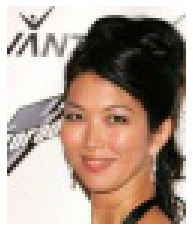

True Label:  tensor(1)
Model output:  tensor([-1.8788,  1.8768])
File name:  163391.jpg


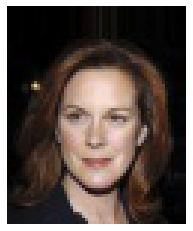

True Label:  tensor(0)
Model output:  tensor([-0.1527,  0.1543])
File name:  162798.jpg


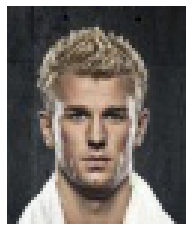

True Label:  tensor(0)
Model output:  tensor([ 3.0205, -3.0197])
File name:  175577.jpg


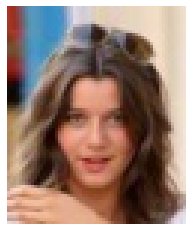

True Label:  tensor(1)
Model output:  tensor([-0.2179,  0.2189])
File name:  180304.jpg


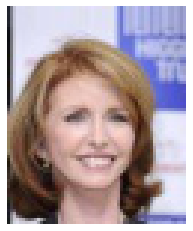

True Label:  tensor(1)
Model output:  tensor([-3.2935,  3.2939])
File name:  166864.jpg


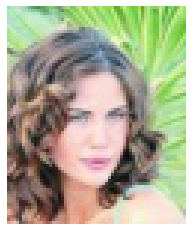

True Label:  tensor(0)
Model output:  tensor([ 1.2875, -1.2878])
File name:  178891.jpg


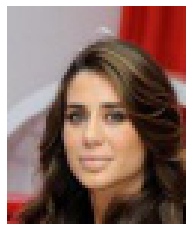

True Label:  tensor(0)
Model output:  tensor([ 0.0404, -0.0408])
File name:  175900.jpg


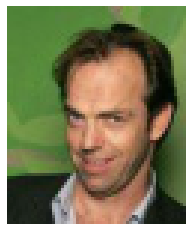

True Label:  tensor(1)
Model output:  tensor([-1.0600,  1.0590])
File name:  167966.jpg


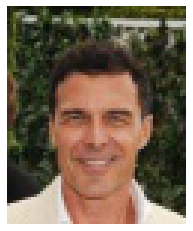

True Label:  tensor(1)
Model output:  tensor([-2.9422,  2.9391])
File name:  179612.jpg


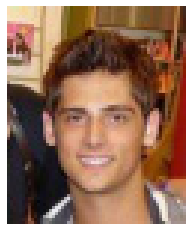

True Label:  tensor(1)
Model output:  tensor([-1.6852,  1.6838])
File name:  178595.jpg


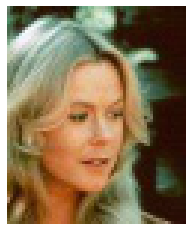

True Label:  tensor(0)
Model output:  tensor([ 0.7830, -0.7839])
File name:  169423.jpg


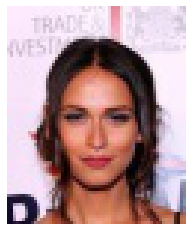

True Label:  tensor(1)
Model output:  tensor([-0.1767,  0.1770])
File name:  164205.jpg


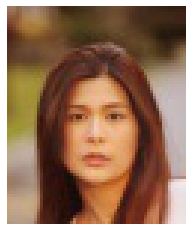

True Label:  tensor(0)
Model output:  tensor([ 4.4464, -4.4451])
File name:  177828.jpg


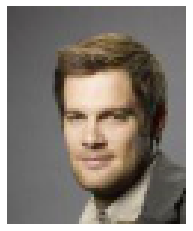

True Label:  tensor(0)
Model output:  tensor([ 1.3360, -1.3341])
File name:  180385.jpg


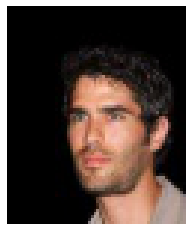

True Label:  tensor(0)
Model output:  tensor([ 2.1756, -2.1776])
File name:  167451.jpg


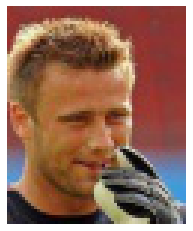

True Label:  tensor(0)
Model output:  tensor([ 0.1465, -0.1485])
File name:  163251.jpg


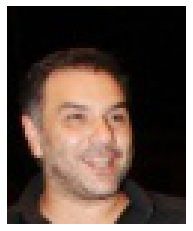

True Label:  tensor(1)
Model output:  tensor([-2.3596,  2.3568])
File name:  173933.jpg


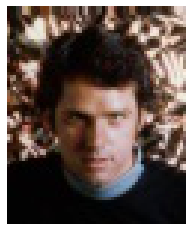

True Label:  tensor(0)
Model output:  tensor([ 2.4966, -2.4971])
File name:  162831.jpg


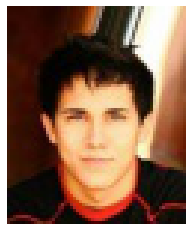

True Label:  tensor(0)
Model output:  tensor([ 1.6985, -1.6992])
File name:  179321.jpg


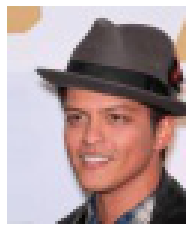

True Label:  tensor(1)
Model output:  tensor([-0.9777,  0.9775])
File name:  171196.jpg


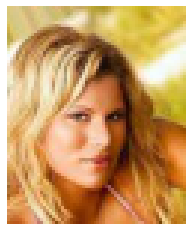

True Label:  tensor(0)
Model output:  tensor([ 0.9821, -0.9809])
File name:  176804.jpg


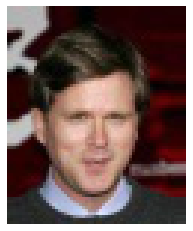

True Label:  tensor(1)
Model output:  tensor([ 0.2361, -0.2365])
File name:  165620.jpg


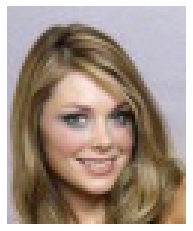

True Label:  tensor(1)
Model output:  tensor([-3.7232,  3.7220])
File name:  168903.jpg


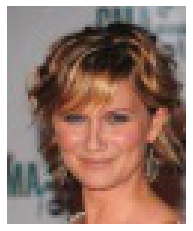

True Label:  tensor(1)
Model output:  tensor([-1.1257,  1.1260])
File name:  177334.jpg


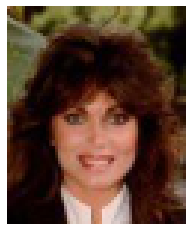

True Label:  tensor(1)
Model output:  tensor([-1.6308,  1.6316])
File name:  162944.jpg


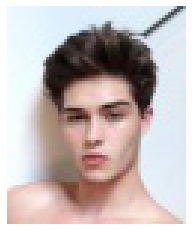

True Label:  tensor(0)
Model output:  tensor([ 4.7934, -4.7929])
File name:  171717.jpg


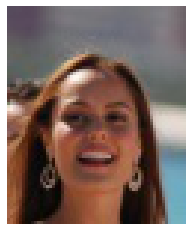

True Label:  tensor(1)
Model output:  tensor([-0.7836,  0.7828])
File name:  177647.jpg


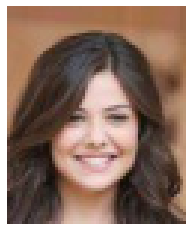

True Label:  tensor(1)
Model output:  tensor([-5.3368,  5.3370])
File name:  171251.jpg


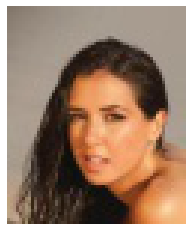

True Label:  tensor(0)
Model output:  tensor([ 1.5157, -1.5170])
File name:  178683.jpg


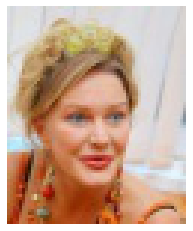

True Label:  tensor(1)
Model output:  tensor([-0.4470,  0.4483])
File name:  177899.jpg


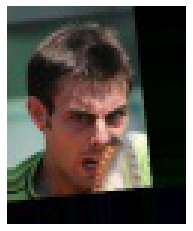

True Label:  tensor(0)
Model output:  tensor([ 0.5668, -0.5683])
File name:  164105.jpg


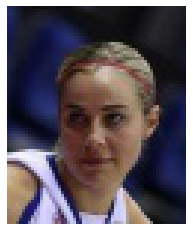

True Label:  tensor(0)
Model output:  tensor([ 0.7185, -0.7191])
File name:  179450.jpg


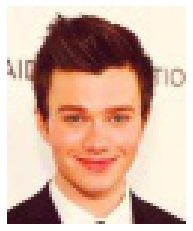

True Label:  tensor(1)
Model output:  tensor([-3.4189,  3.4176])
File name:  167263.jpg


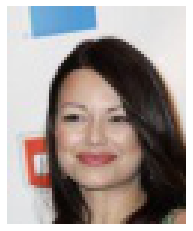

True Label:  tensor(1)
Model output:  tensor([-2.5116,  2.5119])
File name:  164534.jpg


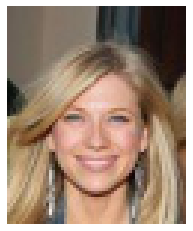

True Label:  tensor(1)
Model output:  tensor([-5.6712,  5.6720])
File name:  173620.jpg


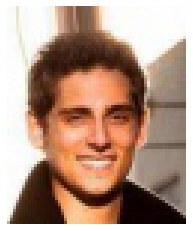

True Label:  tensor(1)
Model output:  tensor([-3.7612,  3.7567])
File name:  180879.jpg


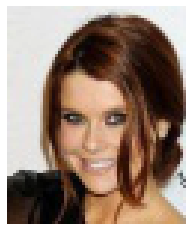

True Label:  tensor(1)
Model output:  tensor([-1.9749,  1.9747])
File name:  181320.jpg


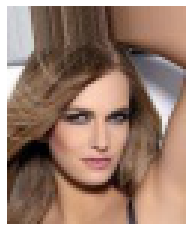

True Label:  tensor(0)
Model output:  tensor([ 1.2997, -1.2980])
File name:  175222.jpg


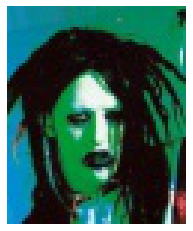

True Label:  tensor(0)
Model output:  tensor([ 1.2225, -1.2219])
File name:  166920.jpg


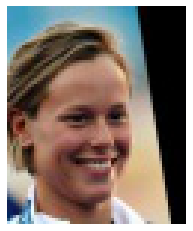

True Label:  tensor(1)
Model output:  tensor([-3.2748,  3.2730])
File name:  173587.jpg


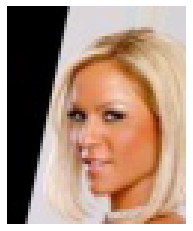

True Label:  tensor(1)
Model output:  tensor([ 0.5031, -0.5036])
File name:  176540.jpg


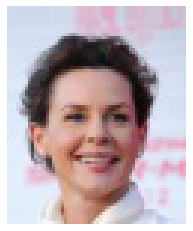

True Label:  tensor(1)
Model output:  tensor([-4.0670,  4.0656])
File name:  169798.jpg


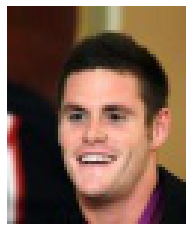

True Label:  tensor(1)
Model output:  tensor([-2.5465,  2.5425])
File name:  170865.jpg


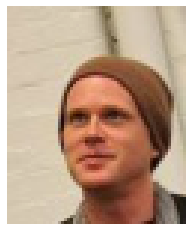

True Label:  tensor(1)
Model output:  tensor([ 1.7520, -1.7509])
File name:  173408.jpg


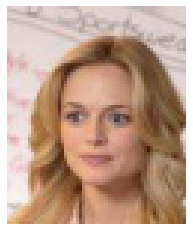

True Label:  tensor(0)
Model output:  tensor([ 0.9344, -0.9337])
File name:  178782.jpg


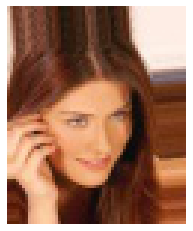

True Label:  tensor(1)
Model output:  tensor([ 0.0352, -0.0339])
File name:  166204.jpg


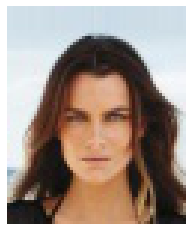

True Label:  tensor(0)
Model output:  tensor([ 1.4936, -1.4939])
File name:  169247.jpg


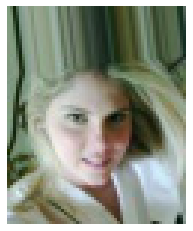

True Label:  tensor(1)
Model output:  tensor([ 0.5194, -0.5165])
File name:  166800.jpg


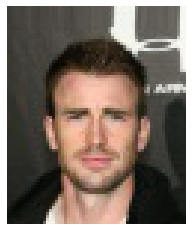

True Label:  tensor(0)
Model output:  tensor([ 1.9647, -1.9637])
File name:  174617.jpg


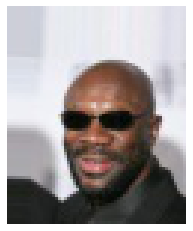

True Label:  tensor(1)
Model output:  tensor([-0.5705,  0.5689])
File name:  174077.jpg


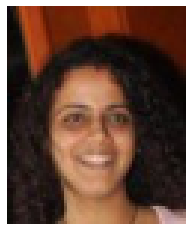

True Label:  tensor(1)
Model output:  tensor([-3.5713,  3.5697])
File name:  171806.jpg


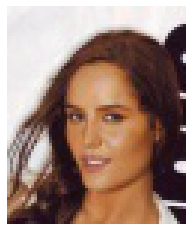

True Label:  tensor(1)
Model output:  tensor([ 0.1942, -0.1955])
File name:  182389.jpg


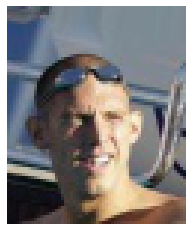

True Label:  tensor(1)
Model output:  tensor([-0.4183,  0.4170])
File name:  168220.jpg


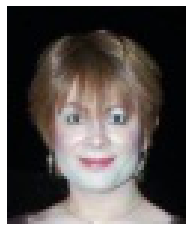

True Label:  tensor(1)
Model output:  tensor([-1.0306,  1.0311])
File name:  177750.jpg


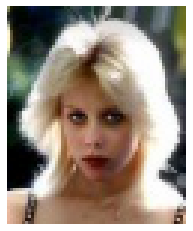

True Label:  tensor(0)
Model output:  tensor([ 1.8324, -1.8326])
File name:  182223.jpg


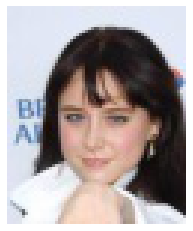

True Label:  tensor(0)
Model output:  tensor([ 0.0701, -0.0691])
File name:  174204.jpg


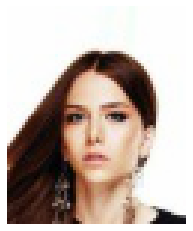

True Label:  tensor(0)
Model output:  tensor([ 4.0774, -4.0763])
File name:  168138.jpg


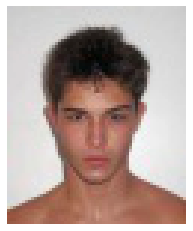

True Label:  tensor(0)
Model output:  tensor([ 3.1349, -3.1351])
File name:  173140.jpg


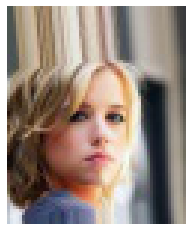

True Label:  tensor(0)
Model output:  tensor([ 3.5891, -3.5895])
File name:  172531.jpg


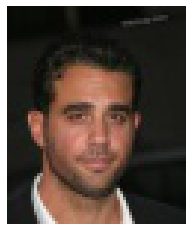

True Label:  tensor(0)
Model output:  tensor([ 1.1206, -1.1220])
File name:  181608.jpg


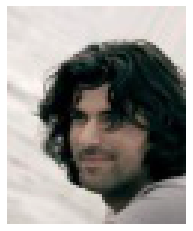

True Label:  tensor(1)
Model output:  tensor([ 0.4157, -0.4150])
File name:  168835.jpg


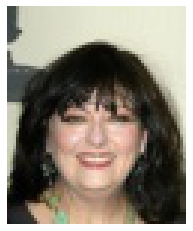

True Label:  tensor(1)
Model output:  tensor([-3.8318,  3.8319])
File name:  167276.jpg


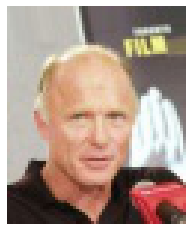

True Label:  tensor(0)
Model output:  tensor([ 2.0024, -2.0023])
File name:  181263.jpg


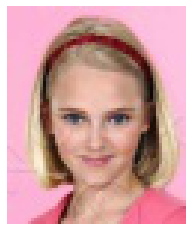

True Label:  tensor(1)
Model output:  tensor([-0.9506,  0.9505])
File name:  174620.jpg


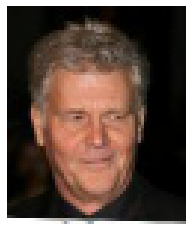

True Label:  tensor(1)
Model output:  tensor([-0.6657,  0.6652])
File name:  179803.jpg


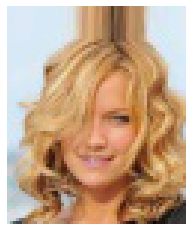

True Label:  tensor(1)
Model output:  tensor([-1.6388,  1.6401])
File name:  179794.jpg


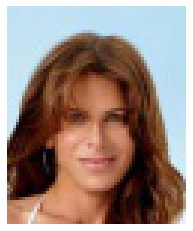

True Label:  tensor(1)
Model output:  tensor([-1.7219,  1.7221])
File name:  170567.jpg


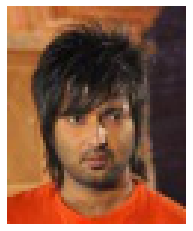

True Label:  tensor(0)
Model output:  tensor([ 1.7873, -1.7848])
File name:  165823.jpg


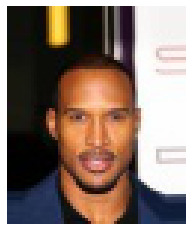

True Label:  tensor(0)
Model output:  tensor([-0.0637,  0.0642])
File name:  171363.jpg


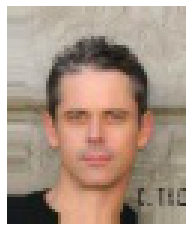

True Label:  tensor(0)
Model output:  tensor([ 2.9175, -2.9177])
File name:  176004.jpg


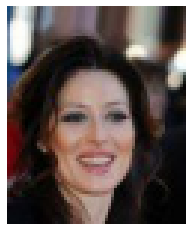

True Label:  tensor(1)
Model output:  tensor([-3.5563,  3.5576])
File name:  169105.jpg


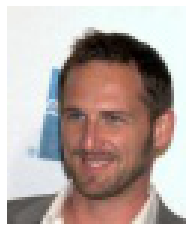

True Label:  tensor(1)
Model output:  tensor([-0.9204,  0.9183])
File name:  173748.jpg


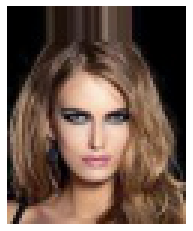

True Label:  tensor(0)
Model output:  tensor([ 3.2044, -3.2030])
File name:  168051.jpg


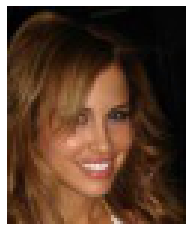

True Label:  tensor(1)
Model output:  tensor([-2.1952,  2.1944])
File name:  167354.jpg


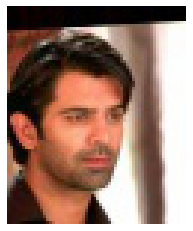

True Label:  tensor(0)
Model output:  tensor([ 1.9527, -1.9539])
File name:  176812.jpg


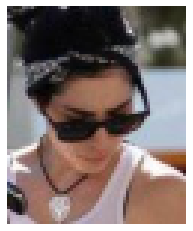

True Label:  tensor(0)
Model output:  tensor([ 0.5884, -0.5891])
File name:  182498.jpg


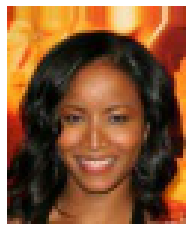

True Label:  tensor(1)
Model output:  tensor([-4.9038,  4.9031])
File name:  163131.jpg


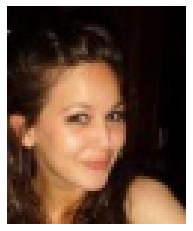

True Label:  tensor(1)
Model output:  tensor([-0.7342,  0.7336])
File name:  168742.jpg


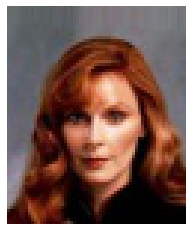

True Label:  tensor(0)
Model output:  tensor([ 2.4561, -2.4530])
File name:  176170.jpg


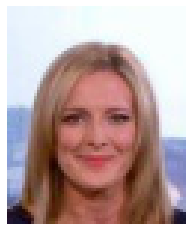

True Label:  tensor(1)
Model output:  tensor([-2.9268,  2.9271])
File name:  167436.jpg


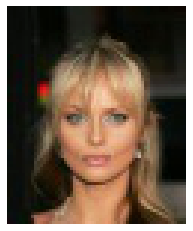

True Label:  tensor(0)
Model output:  tensor([ 2.4489, -2.4470])
File name:  167365.jpg


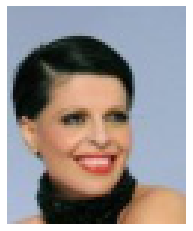

True Label:  tensor(1)
Model output:  tensor([-4.4725,  4.4697])
File name:  165190.jpg


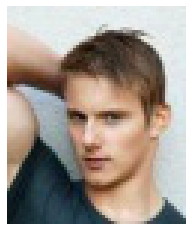

True Label:  tensor(0)
Model output:  tensor([ 3.1404, -3.1402])
File name:  170600.jpg


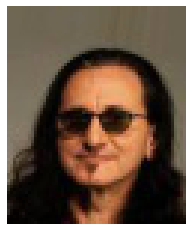

True Label:  tensor(0)
Model output:  tensor([ 0.6214, -0.6203])
File name:  171727.jpg


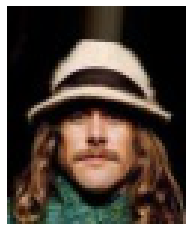

True Label:  tensor(0)
Model output:  tensor([ 1.7815, -1.7811])
File name:  172569.jpg


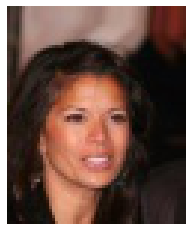

True Label:  tensor(0)
Model output:  tensor([-0.4613,  0.4621])
File name:  175226.jpg


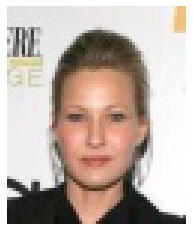

True Label:  tensor(0)
Model output:  tensor([ 1.5869, -1.5864])
File name:  180956.jpg


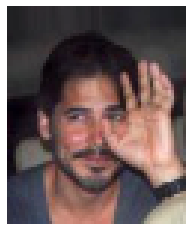

True Label:  tensor(0)
Model output:  tensor([ 1.4988, -1.4989])
File name:  167720.jpg


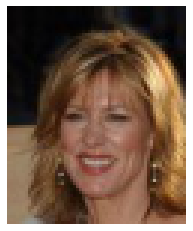

True Label:  tensor(1)
Model output:  tensor([-2.3532,  2.3517])
File name:  173900.jpg


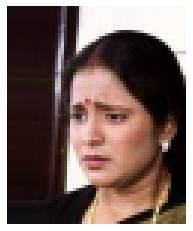

True Label:  tensor(0)
Model output:  tensor([ 3.5550, -3.5551])
File name:  181936.jpg


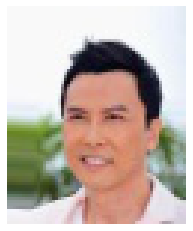

True Label:  tensor(1)
Model output:  tensor([-0.6202,  0.6200])
File name:  174307.jpg


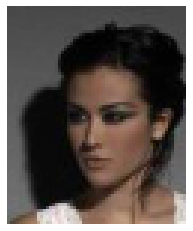

True Label:  tensor(0)
Model output:  tensor([ 1.9162, -1.9161])
File name:  172715.jpg


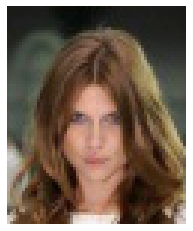

True Label:  tensor(0)
Model output:  tensor([ 1.1080, -1.1081])
File name:  180620.jpg


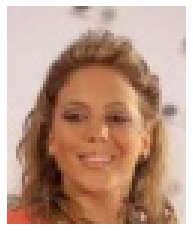

True Label:  tensor(1)
Model output:  tensor([-2.7124,  2.7128])
File name:  182461.jpg


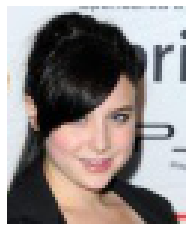

True Label:  tensor(1)
Model output:  tensor([-2.3780,  2.3797])
File name:  178825.jpg


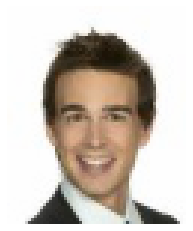

True Label:  tensor(1)
Model output:  tensor([-4.0195,  4.0176])
File name:  166114.jpg


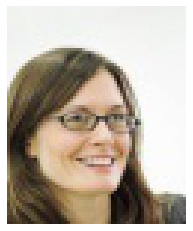

True Label:  tensor(1)
Model output:  tensor([-3.7014,  3.7001])
File name:  176403.jpg


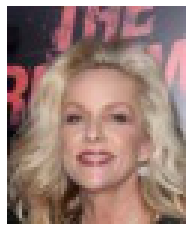

True Label:  tensor(1)
Model output:  tensor([-0.6703,  0.6704])
File name:  167165.jpg


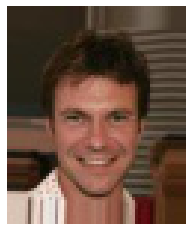

True Label:  tensor(1)
Model output:  tensor([-4.8218,  4.8211])
File name:  182323.jpg


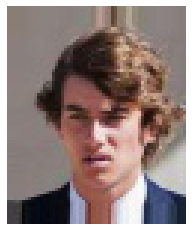

True Label:  tensor(0)
Model output:  tensor([ 2.2947, -2.2953])
File name:  171410.jpg


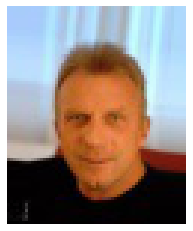

True Label:  tensor(0)
Model output:  tensor([ 0.8835, -0.8841])
File name:  179556.jpg


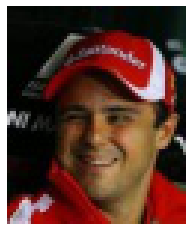

True Label:  tensor(1)
Model output:  tensor([-2.5507,  2.5491])
File name:  175860.jpg


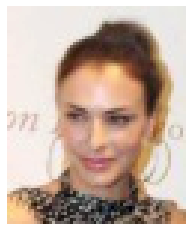

True Label:  tensor(1)
Model output:  tensor([-0.7182,  0.7182])
File name:  175702.jpg


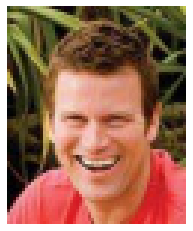

True Label:  tensor(1)
Model output:  tensor([-5.4176,  5.4164])
File name:  163401.jpg


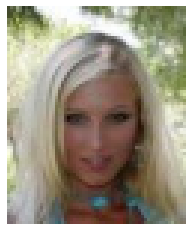

True Label:  tensor(1)
Model output:  tensor([ 0.2849, -0.2845])
File name:  179622.jpg


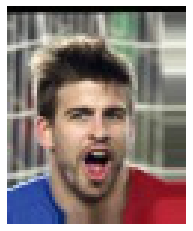

True Label:  tensor(0)
Model output:  tensor([ 2.1691, -2.1679])
File name:  177844.jpg


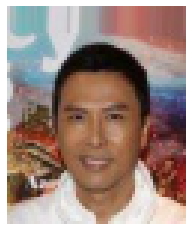

True Label:  tensor(1)
Model output:  tensor([-0.6130,  0.6130])
File name:  165919.jpg


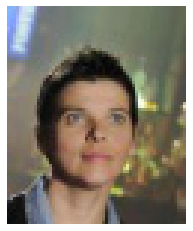

True Label:  tensor(0)
Model output:  tensor([ 2.3782, -2.3777])
File name:  179842.jpg


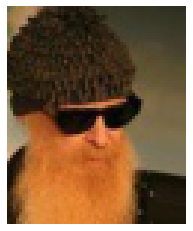

True Label:  tensor(0)
Model output:  tensor([ 1.3139, -1.3137])
File name:  180697.jpg


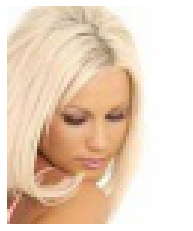

True Label:  tensor(0)
Model output:  tensor([ 0.9119, -0.9137])
File name:  167668.jpg


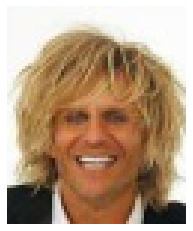

True Label:  tensor(1)
Model output:  tensor([-4.4753,  4.4727])
File name:  177371.jpg


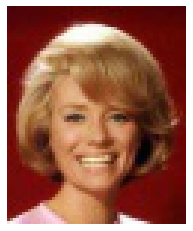

True Label:  tensor(1)
Model output:  tensor([-5.3183,  5.3200])
File name:  170839.jpg


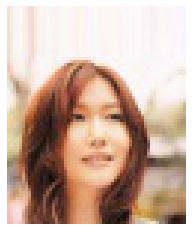

True Label:  tensor(0)
Model output:  tensor([-0.2928,  0.2932])
File name:  178066.jpg


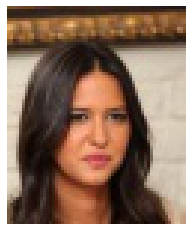

True Label:  tensor(0)
Model output:  tensor([ 2.2193, -2.2179])
File name:  167084.jpg


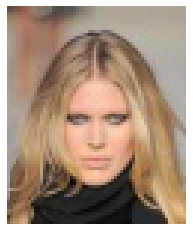

True Label:  tensor(0)
Model output:  tensor([ 1.6739, -1.6728])
File name:  164459.jpg


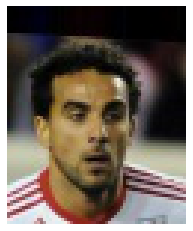

True Label:  tensor(0)
Model output:  tensor([ 2.6945, -2.6934])
File name:  167740.jpg


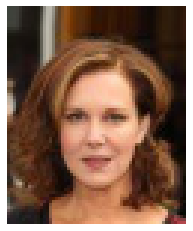

True Label:  tensor(0)
Model output:  tensor([ 0.2413, -0.2410])
File name:  175928.jpg


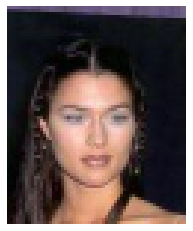

True Label:  tensor(0)
Model output:  tensor([ 2.2199, -2.2193])
File name:  173232.jpg


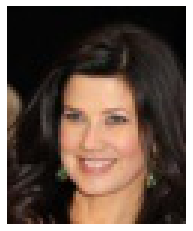

True Label:  tensor(1)
Model output:  tensor([-3.3727,  3.3695])
File name:  177496.jpg


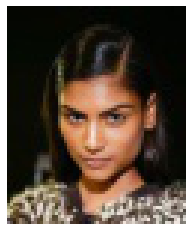

True Label:  tensor(0)
Model output:  tensor([ 2.1468, -2.1464])
File name:  169632.jpg


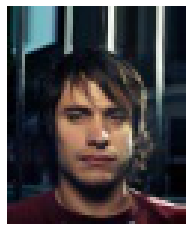

True Label:  tensor(0)
Model output:  tensor([ 2.6643, -2.6631])
File name:  171424.jpg


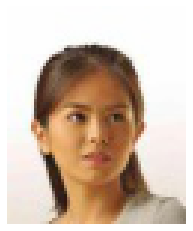

True Label:  tensor(0)
Model output:  tensor([ 1.4230, -1.4225])
File name:  177060.jpg


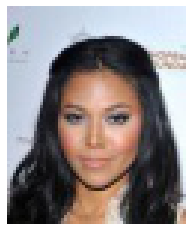

True Label:  tensor(1)
Model output:  tensor([-0.1053,  0.1063])
File name:  164665.jpg


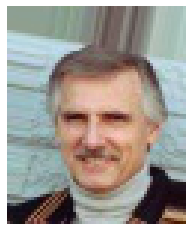

True Label:  tensor(1)
Model output:  tensor([-2.1242,  2.1245])
File name:  180043.jpg


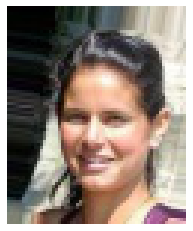

True Label:  tensor(1)
Model output:  tensor([-2.3323,  2.3323])
File name:  170515.jpg


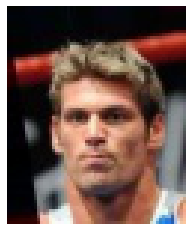

True Label:  tensor(0)
Model output:  tensor([ 2.7684, -2.7673])
File name:  163624.jpg


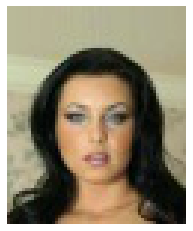

True Label:  tensor(0)
Model output:  tensor([ 2.7497, -2.7493])
File name:  170420.jpg


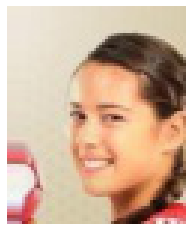

True Label:  tensor(1)
Model output:  tensor([-0.9611,  0.9591])
File name:  177122.jpg


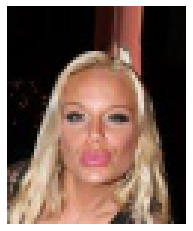

True Label:  tensor(0)
Model output:  tensor([ 1.3027, -1.3014])
File name:  181765.jpg


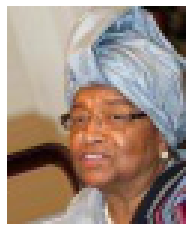

True Label:  tensor(0)
Model output:  tensor([ 0.7172, -0.7149])
File name:  163214.jpg


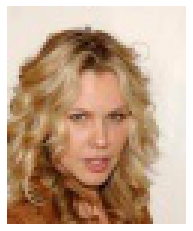

True Label:  tensor(0)
Model output:  tensor([ 2.1359, -2.1350])
File name:  177134.jpg


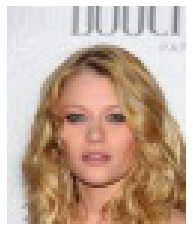

True Label:  tensor(0)
Model output:  tensor([ 2.0303, -2.0273])
File name:  182550.jpg


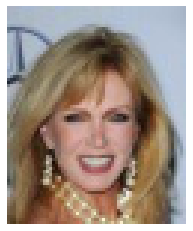

True Label:  tensor(1)
Model output:  tensor([-2.9795,  2.9806])
File name:  165874.jpg


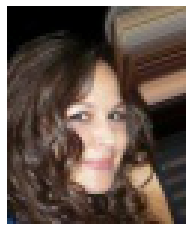

True Label:  tensor(1)
Model output:  tensor([-0.7839,  0.7833])
File name:  174608.jpg


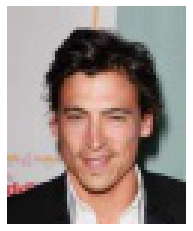

True Label:  tensor(1)
Model output:  tensor([-0.8803,  0.8806])
File name:  182608.jpg


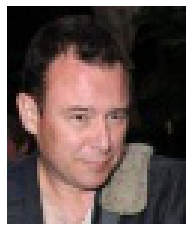

True Label:  tensor(0)
Model output:  tensor([ 0.4232, -0.4226])
File name:  182304.jpg


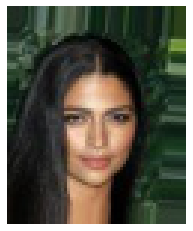

True Label:  tensor(0)
Model output:  tensor([ 0.9122, -0.9103])
File name:  168967.jpg


In [75]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
valid_predictions = valid_predictions.astype(object)
j=0
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        if j == 2:
            break
        j+=1
        for i in range(len(batch_valid['file'])):
            plt.figure()
            plt.imshow(np.transpose(vutils.make_grid(batch_valid['image'][i], padding=2,normalize=True).cpu(),(1,2,0)))
            plt.axis('off')
            plt.ioff()
            plt.show()
            print('True Label: ',labels_argmax[i]) 
            print('Model output: ', output['out'][i])
            print('File name: ', batch_valid['file'][i])
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [35]:
# Should be equalt to validation accuracy in df
np.mean(valid_predictions['accuracy'])

0.9156935776122408

In [18]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP','val_1_FN','val_0_FN'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])
    df_att.iloc[att]['val_1_FN'] = 1-np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_FN'] = 1-np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [19]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP']
df_att['acc_ratio'] = df_att['val_1_acc'] /df_att['val_0_acc']
df_att['FN_OR'] = df_att['val_1_FN'] /df_att['val_0_FN'] 
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])
df_att['acc_ratio'] = pd.to_numeric(df_att['acc_ratio'])
df_att['FN_OR'] = pd.to_numeric(df_att['FN_OR'])


In [20]:
df_att = df_att.sort_values('acc_ratio')

In [21]:
df_att2 = df_att.loc[['Rosy_Cheeks','Gray_Hair','Mustache','Sideburns','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Chubby','Double_Chin','Heavy_Makeup','Eyeglasses','Goatee','High_Cheekbones','Pale_Skin','Male','Mouth_Slightly_Open','Young']].sort_values('acc_ratio')

In [22]:
df_att2[['acc_ratio','FN_OR','FP_OR']]

acc_ratio     FN_OR     FP_OR
Gray_Hair             0.953194  1.026397  2.714936
Chubby                0.957505  0.977697  2.691900
Eyeglasses            0.962360  1.421740  1.743933
Goatee                0.964947  2.013096  1.330631
Double_Chin           0.971952  0.656918  3.673126
Mustache              0.971962  1.852978  1.350733
Sideburns             0.974467  1.977496  1.065686
Male                  0.981636  1.575085  1.004023
Bald                  0.993574  0.451136  2.651754
High_Cheekbones       0.997805  0.248828  3.849472
Big_Nose              1.004269  0.623606  1.745507
Attractive            1.006536  0.832386  0.747626
Heavy_Makeup          1.009298  0.729840  0.936648
Bags_Under_Eyes       1.009795  0.579224  1.663285
Bangs                 1.016997  0.713152  0.981650
Arched_Eyebrows       1.022094  0.563560  1.191746
Big_Lips              1.022313  0.750639  0.881283
Young                 1.024780  1.124424  0.434525
Pale_Skin             1.029536  0.751202  0.806879
Mouth_Slightly_Open   1.032109  0.198039  2.474585
Rosy_Cheeks           1.044522  0.285270  2.441248

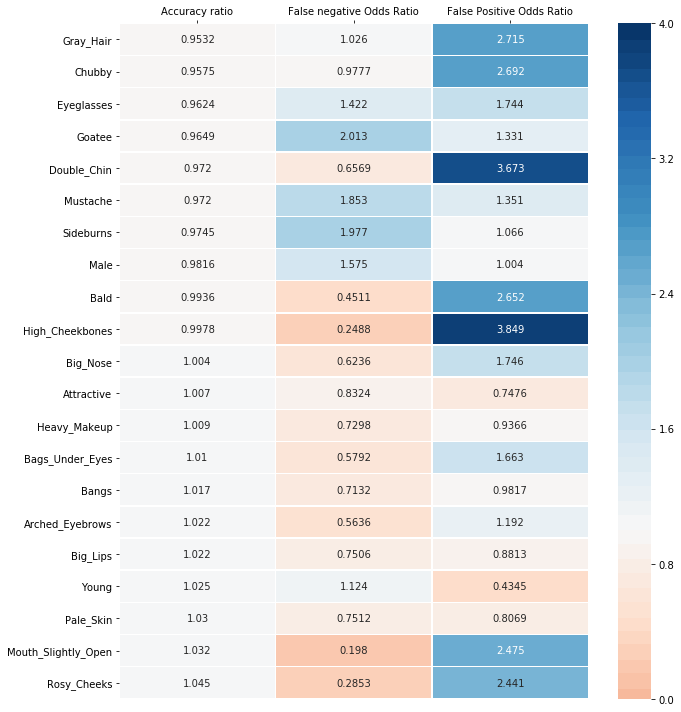

In [29]:
plt.figure(figsize = (10,10))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=4, cmap=cmap,annot=True, linewidths=.5, fmt='.4g')
ax = sns.heatmap(df_att2[['acc_ratio','FN_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['Accuracy ratio','False negative Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att2.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig('heat.png',dpi=500)

In [42]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    pred_label = torch.max(get_labels(sample_batched), 1)[1]
    
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        #print(bias[i])
        print('Output of NN: ',output['out'][i])
        print('Predicted label: ', pred_label[i])

In [45]:
batch_valid

{'file': ['charlotte.jpg'],
 'image': tensor([[[[199., 199., 199.,  ..., 217., 216., 216.],
           [202., 202., 202.,  ..., 219., 219., 219.],
           [202., 202., 202.,  ..., 220., 220., 220.],
           ...,
           [ 59.,  58.,  52.,  ...,  93.,  84.,  75.],
           [ 58.,  57.,  52.,  ...,  93.,  85.,  74.],
           [ 60.,  60.,  52.,  ...,  93.,  82.,  70.]],
 
          [[195., 195., 195.,  ..., 213., 212., 212.],
           [198., 198., 198.,  ..., 215., 215., 215.],
           [198., 198., 198.,  ..., 216., 216., 216.],
           ...,
           [ 17.,  18.,  15.,  ...,  43.,  37.,  28.],
           [ 16.,  17.,  15.,  ...,  43.,  35.,  27.],
           [ 18.,  20.,  17.,  ...,  43.,  32.,  22.]],
 
          [[184., 184., 184.,  ..., 204., 203., 203.],
           [187., 187., 187.,  ..., 206., 206., 206.],
           [187., 187., 187.,  ..., 207., 207., 207.],
           ...,
           [ 27.,  27.,  23.,  ...,  54.,  47.,  38.],
           [ 26.,  26.,  23.,

<Figure size 432x288 with 0 Axes>

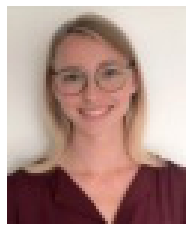

tensor([0., 1.], dtype=torch.float64)


KeyError: 0

In [44]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()

In [50]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\images_resize\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [51]:
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        ac = accuracy(output['out'],labels_argmax)
        print(ac)

tensor(0.8000)


In [52]:
output

{'out': tensor([[-1.7870,  1.7862],
         [-0.1785,  0.1781],
         [-2.7959,  2.7955],
         [-3.3320,  3.3327],
         [ 1.2387, -1.2403]])}

In [53]:
batch_valid

{'file': ['martin.jpg', 'ole.jpg', 'charlotte.jpg', '000108.jpg', 'pratt.jpg'],
 'image': tensor([[[[171., 171., 170.,  ..., 214., 216., 218.],
           [165., 165., 167.,  ..., 216., 218., 220.],
           [160., 160., 162.,  ..., 218., 220., 222.],
           ...,
           [116., 116., 118.,  ...,  75.,  65.,  71.],
           [117., 115., 116.,  ...,  77.,  78.,  82.],
           [112., 110., 110.,  ...,  82.,  79.,  80.]],
 
          [[184., 184., 184.,  ..., 224., 226., 228.],
           [178., 178., 180.,  ..., 226., 228., 230.],
           [170., 173., 175.,  ..., 228., 230., 232.],
           ...,
           [137., 137., 139.,  ...,  80.,  70.,  76.],
           [137., 135., 136.,  ...,  81.,  82.,  86.],
           [132., 130., 130.,  ...,  83.,  80.,  84.]],
 
          [[193., 193., 193.,  ..., 234., 236., 238.],
           [187., 187., 189.,  ..., 236., 238., 240.],
           [180., 182., 184.,  ..., 238., 240., 242.],
           ...,
           [128., 128., 130.,  .